## Summary
This project performs clustering analysis using a few factors, then use the clustersfor "classification neutral" stock selction. We will compare this neutrality strategy to a more traditional sector neutral strategy.

### 1. Import package & variables setup

In [1]:
import pandas as pd
import numpy as np
from os import path
import os

# import KMeans
from sklearn.cluster import KMeans

# data viz packages
import matplotlib.pyplot as plt
import plotly.graph_objects as plty
from plotly.subplots import make_subplots

In [116]:
clr1 = ["#00ab4e","#58595b","#939598","#000000","#FFFFFF"]
clr2 = ["#009697","#8dc63f","#f7941d","#ee2f53","#00b5f1","#96157c","#00ab4e","#58595b"]

sc_path = r'C:\Users\patrick.fang\OneDrive - IHS Markit\ResearchSignals\Projects\20200213_StockClustering'
file1 = 'Factor_data_USLC_2019.txt'
file2 = 'Factor_data_USTC_2019.txt'


### 2. Load data

In [3]:
sc_data = pd.read_csv(path.join(sc_path,file1), sep='\t')
sc_data.head()

Date  FactorId SecurityId  Rank  RawRatio
0  2019-01-31 00:00:00        29   02376R10  9255  -0.01026
1  2019-01-31 00:00:00        29   02393410  2107   1.07825
2  2019-01-31 00:00:00        29   03042010  6289   0.33917
3  2019-01-31 00:00:00        29   03673L10  6409   0.32404
4  2019-01-31 00:00:00        29   04247X10  8366   0.09735

Factor & ID mapping

|Factor|Factor ID|Factor Name|
|------|---------|-----------|
|ROIC|249|Return on Invested Capital|
|FCFROI|146|Free Cash Flow Return on Invested Capital|
|EBITDAP|106|TTM EV/EBITDA|
|TTMSP|304|TTM Price to Sale|
|ChgShare|73|Percent Change in Shares Outstanding|
|BP|29|Book-to-Market|


In [4]:
# test = sc_data.loc[(sc_data.Date == '2019-01-31 00:00:00') & (sc_data.FactorId == 29),]
# test.shape

sc_data.groupby(['Date','FactorId']).Rank.median()

Date                 FactorId
2019-01-31 00:00:00  29          6208.5
                     73          1456.0
                     106         3985.0
                     146         2638.0
                     249         2763.0
                                  ...  
2020-02-12 00:00:00  73          2387.0
                     106         4386.0
                     146         2596.5
                     249         2693.0
                     304         5391.5
Name: Rank, Length: 84, dtype: float64

In [149]:
# Creating crosssectional ranking columns

sc_data['cs_PRank'] = sc_data.groupby(['Date','FactorId']).Rank.rank(pct=True)

sc_data.sort_values(['Date','SecurityId']).head()
sc_data[(sc_data.SecurityId == 'HOLX') & (sc_data.Date == '2019-01-31 00:00:00')]

# double check the percentile ranck, look good
# sc_data.loc[(sc_data.Date == '2019-01-31 00:00:00') & 
#             (sc_data.FactorId == 29) & 
#             (sc_data.prank < 0.05),].sort_values(['prank'])



Date  FactorId SecurityId  Rank  RawRatio  cs_PRank
3305   2019-01-31 00:00:00        29       HOLX  7470   0.20173  0.696043
25150  2019-01-31 00:00:00        73       HOLX   790  -1.89100  0.283759
32902  2019-01-31 00:00:00       106       HOLX  6144   0.01760  0.920981
40179  2019-01-31 00:00:00       146       HOLX  1352   0.10820  0.271493
63655  2019-01-31 00:00:00       249       HOLX  6626  -0.05537  0.952839
90085  2019-01-31 00:00:00       304       HOLX  6229   0.27095  0.673561

In [6]:
test = sc_data[sc_data.FactorId == 29].RawRatio
test.shape

(15729,)

### 3. Examine data

In [153]:
### pivot table the data to have factors as columns and PRank as values
a = sc_data.pivot_table(index=['Date','SecurityId'], columns='FactorId', values='cs_PRank', fill_value = 0)

type(a)
a.columns = ['BP','ChgShare','EBITDAP','FCFROI','ROIC','TTMSP']
a.head()

BP  ChgShare   EBITDAP    FCFROI  \
Date                SecurityId                                           
2019-01-31 00:00:00 00090Q10    0.153777  0.801095  0.040872  0.380995   
                    00163T10    0.334532  0.958942  0.711172  0.918552   
                    00164V10    0.881295  0.028285  0.013624  0.170136   
                    00287Y10    0.964928  0.094891  0.542234  0.095928   
                    00766T10    0.127698  0.443431  0.349682  0.353846   

                                    ROIC     TTMSP  
Date                SecurityId                      
2019-01-31 00:00:00 00090Q10    0.742674  0.253597  
                    00163T10    0.687729  0.941547  
                    00164V10    0.195055  0.263489  
                    00287Y10    0.077839  0.680755  
                    00766T10    0.808608  0.018885

In [168]:
b = a.loc['2019-01-31 00:00:00']
b.index.names
b.index

Index(['00090Q10', '00163T10', '00164V10', '00287Y10', '00766T10', '00847X10',
       '00912X30', '01527110', '01858110', '01973R10',
       ...
       'YRI', 'YUM', 'YUMCWI', 'Z', 'ZAP', 'ZAYO', 'ZBRA', 'ZCVVV', 'ZION',
       'ZMRH'],
      dtype='object', name='SecurityId', length=1112)

In [185]:
# scatter plot two factors, check both raw ratio & PRank
fig1 = plty.Figure()
fig1.add_trace(plty.Scatter(x=b.EBITDAP.values, 
                            y=b.ROIC.values, 
                            mode='markers',
                            text=b.index,
                            marker_color=clr1[0]))
fig1.update_layout(
    title = 'Scatterplot of EBITDAP vs. ROIC',
    yaxis_title = 'ROIC Percentile',
    xaxis_title = 'TTM EV/EBITDA Percentile'
)
fig1.show()



### 4. K-Means Clustering


In [140]:
### test indexing data under multiindex framework

# a.index.names

#a[[29,73]]

a.loc[['2019-01-31 00:00:00'],('EBITDAP','ROIC')]


EBITDAP      ROIC
Date                SecurityId                    
2019-01-31 00:00:00 00090Q10    0.040872  0.742674
                    00163T10    0.711172  0.687729
                    00164V10    0.013624  0.195055
                    00287Y10    0.542234  0.077839
                    00766T10    0.349682  0.808608
...                                  ...       ...
                    ZAYO        0.195277  0.737179
                    ZBRA        0.623978  0.245421
                    ZCVVV       0.960945  0.935440
                    ZION        0.256131  0.382784
                    ZMRH        0.628520  0.847070

[1112 rows x 2 columns]

In [132]:
# create data sample in array
dsamp = a.loc['2019-01-31 00:00:00',('EBITDAP','ROIC')].values

# create kmeans object
kmeans = KMeans(n_clusters=8)
# fit kmeans object to data
kmeans.fit(dsamp)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(dsamp)

[[0.14550992 0.20964815]
 [0.49011883 0.79098367]
 [0.82656644 0.12404528]
 [0.11788294 0.752252  ]
 [0.72501362 0.5130696 ]
 [0.88301269 0.89871934]
 [0.52802895 0.1866732 ]
 [0.28931258 0.48942839]]


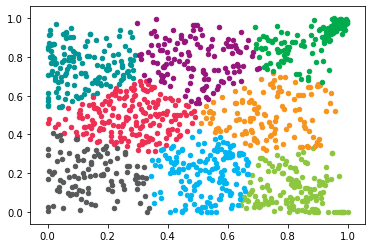

In [170]:
# Scatter plot the clusters

plt.scatter(dsamp[y_km ==0,0], dsamp[y_km == 0,1], s=20, c=clr2[0])
plt.scatter(dsamp[y_km ==1,0], dsamp[y_km == 1,1], s=20, c=clr2[1])
plt.scatter(dsamp[y_km ==2,0], dsamp[y_km == 2,1], s=20, c=clr2[2])
plt.scatter(dsamp[y_km ==3,0], dsamp[y_km == 3,1], s=20, c=clr2[3])
plt.scatter(dsamp[y_km ==4,0], dsamp[y_km == 4,1], s=20, c=clr2[4])
plt.scatter(dsamp[y_km ==5,0], dsamp[y_km == 5,1], s=20, c=clr2[5])
plt.scatter(dsamp[y_km ==6,0], dsamp[y_km == 6,1], s=20, c=clr2[6])
plt.scatter(dsamp[y_km ==7,0], dsamp[y_km == 7,1], s=20, c=clr2[7])

In [171]:
fig2 = plty.Figure()
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==0,0], y=dsamp[y_km == 0,1], mode='markers',marker_color=clr2[0]))
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==1,0], y=dsamp[y_km == 1,1], mode='markers',marker_color=clr2[1]))
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==2,0], y=dsamp[y_km == 2,1], mode='markers',marker_color=clr2[2]))
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==3,0], y=dsamp[y_km == 3,1], mode='markers',marker_color=clr2[3]))
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==4,0], y=dsamp[y_km == 4,1], mode='markers',marker_color=clr2[4]))
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==5,0], y=dsamp[y_km == 5,1], mode='markers',marker_color=clr2[5]))
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==6,0], y=dsamp[y_km == 6,1], mode='markers',marker_color=clr2[6]))
fig2.add_trace(plty.Scatter(x=dsamp[y_km ==7,0], y=dsamp[y_km == 7,1], mode='markers',marker_color=clr2[7]))
fig2.update_layout(
    title = 'Cluster Plot of EBITDAP vs. ROIC',
    yaxis_title = 'ROIC Percentile',
    xaxis_title = 'TTM EV/EBITDA Percentile'
)
fig2.show()

### 5. Hierachical Clustering

In [112]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

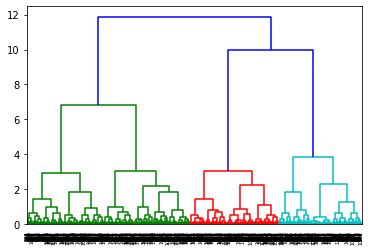

In [113]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(dsamp, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(dsamp)

### 6. Create Cluster Groupings in original dataset

In [182]:
y_km

array([0, 2, 7, ..., 6, 3, 5])